In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GraphClass:
    def __init__(self, graph):
        print(graph)
        self.graph = graph

        # create adjacency matrix
        self.adj_matrix = nx.adjacency_matrix(self.graph).todense()

        # == nodes ==
        # degree
        self.degrees = self.adj_matrix.sum(axis=1).reshape((-1, 1))

        # opinion
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

        # conformity
        self.conformity = np.array(list(nx.get_node_attributes(self.graph, "conformity").values())).reshape((-1, 1))

        # node_centrality
        self.node_centrality = np.array(list(nx.get_node_attributes(self.graph, "node_centrality").values())).reshape((-1, 1))
        
        # == edges ==
        # weight on edges
        self.weight = nx.attr_matrix(self.graph, edge_attr='weight')[0]


In [3]:
class ExperimentClass(GraphClass):
    def __init__(self, graph: nx.Graph, model_name: str):
        super().__init__(graph)
        self.model_name = model_name
        self.opinions_per_iter = []

    def run_model(self, steps: int):
        self.initial_opinions = self.opinions.copy()

        for _ in range(1, steps):
            if self.model_name == 'FJ':
                w_ii = np.diag(self.weight).reshape((-1, 1)) # weights on self-loop edges
                new_opinions = (1 - w_ii) * (self.adj_matrix * self.weight @ self.opinions) + (w_ii * self.initial_opinions)
            if self.model_name == 'New':
                new_opinions = self.conformity * self.opinions + (1 - self.conformity) * (self.adj_matrix * self.node_centrality @ self.opinions) / self.degrees

            self._update_graph(new_opinions)
            self.opinions_per_iter.append(new_opinions)

    def _update_graph(self, new_opinions):
        for i, node in enumerate(self.graph.nodes):
            self.graph.nodes[node]['opinion'] = new_opinions[i][0]
        
        self.opinions = np.array(list(nx.get_node_attributes(self.graph, "opinion").values())).reshape((-1, 1))

    def plot(self):
        # plot each time of sum of opinions
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(np.array(self.opinions_per_iter).sum(axis=1))
        ax.set_xlabel('time')
        ax.set_ylabel('sum of opinions')
        ax.set_title(f'Sum of opinions over time ({self.model_name})')
        plt.show()

    def get_opinions_per_iter(self):
        return self.opinions_per_iter

In [9]:
from read_networks import read_citation_graph

# create random graph
# g = nx.erdos_renyi_graph(n=100, p=0.5, seed=42)  # random graph
g = read_citation_graph(field='History', graph=nx.Graph())  # undirected citation graph (History or Physics)

# add node properties such as weight and opinion
for node in g.nodes:
    g.nodes[node]['opinion'] = np.random.rand()
    g.nodes[node]['conformity'] = np.random.rand()
    g.nodes[node]['node_centrality'] = np.random.rand()

# add edge weight
for e1, e2 in g.edges:
    g.edges[e1, e2]['weight'] = np.random.rand()

# # display thier properties
# for node in g.nodes:
#     print(g.nodes[node])

Graph with 902 nodes and 965 edges


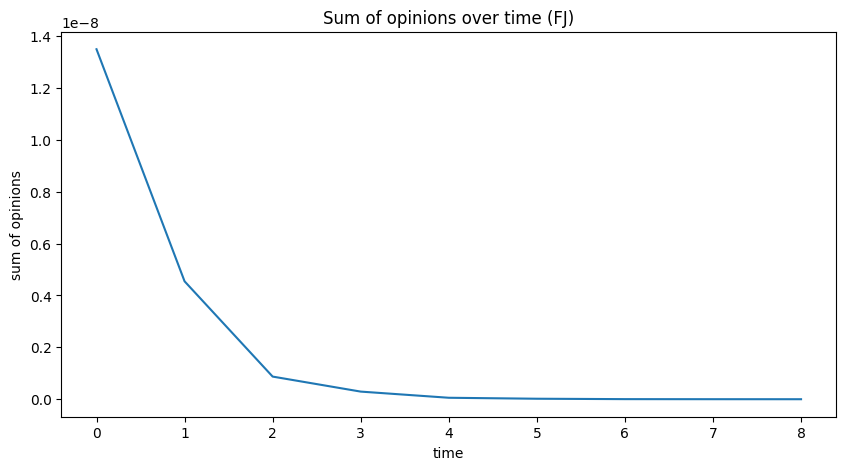

In [12]:
test = ExperimentClass(g, 'FJ')
test.run_model(10)
test.plot()

Graph with 902 nodes and 965 edges


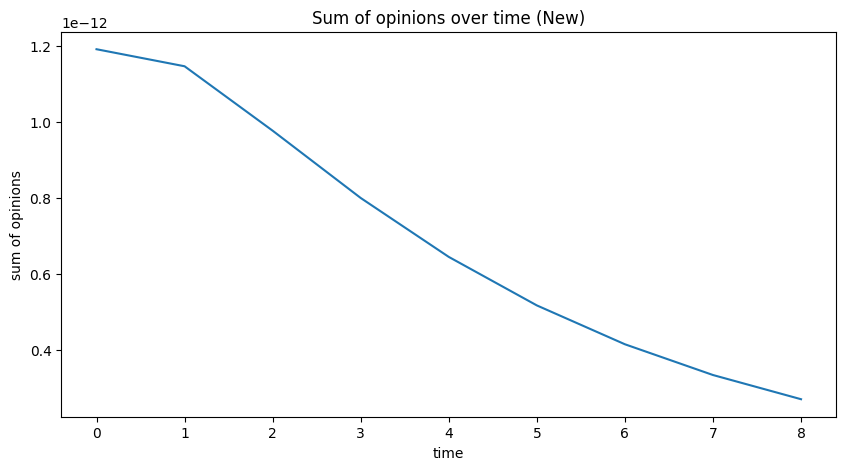

In [13]:
test = ExperimentClass(g, 'New')
test.run_model(10)
test.plot()